# Risk Measurement and Backtesting

This notebook examines different Valute at Risk estimation techniques back-tests these on a equally weighted portfolio of US stocks. The Value at Risk estimation techniques will be based on both parametric and non-parametric approaches. 

* **Parametric Approach**:
    * Return Distribution is normally distributed
* **Non-Parametric Appraoch**:
    * Rolling historical data
    * Rolling historical data adjusted for current volatility

After time series of (ex-ante) Value at Risk predictions has been made for each appraoch, hypothesis tests can be made to test the validity of each methods predictive capability as well as its clustering tendencies. This is based of the number of Value at Risk exceedences of ex-post returns, if the models are correct, they would estimate the number of exceedences well. However, firstly a test based of Christoffersson (1998) using likelihood ratios will be made to examine the serial dependency of Value at Risk exceedences. If the time series does not exhibit serial correlation, tests regarding the number of exceedences are justified to a greater extent.

Generally, Value at Risk can be quoted in two ways. The dollar amount at risk of being lost, or the potential percentage loss. In this notewook we will work exclusivley with quoting Value at Risk as a percentage loss, since this is invariant to the portfolio value.

Data will be fetched from Yahoo Finance and the portfolio will be based of the stocks:

* Microsoft (MSFT)
* Wells Fargo (WTC)
* Verizon (VZ)
* AT&T (T)
* Coca Cola (KO)
* Boeing (BA)

Note: the methodology is easily extended for additional assets including international assets, so long as currency effects are taken into consideration in finding the return distribution.

---

### Data Fetching and Historical Return Distribution

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pandas_datareader import data as pdr

portfolio_codes = ['MSFT', 'WFC', 'VZ', 'T', 'KO', 'BA']
portfolio_weights = 1/len(portfolio_codes)
portfolio_data = pdr.get_data_yahoo(portfolio_codes, start="2011-12-28", end="2021-12-28", interval="wk")['Adj Close']
portfolio_data['EqWPortfolio'] =  (portfolio_weights * portfolio_data).sum(axis=1)
portfolio_returns = portfolio_data[1:]/portfolio_data.shift(1)[1:] - 1

portfolio_codes.append('EqWPort')

In [ ]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


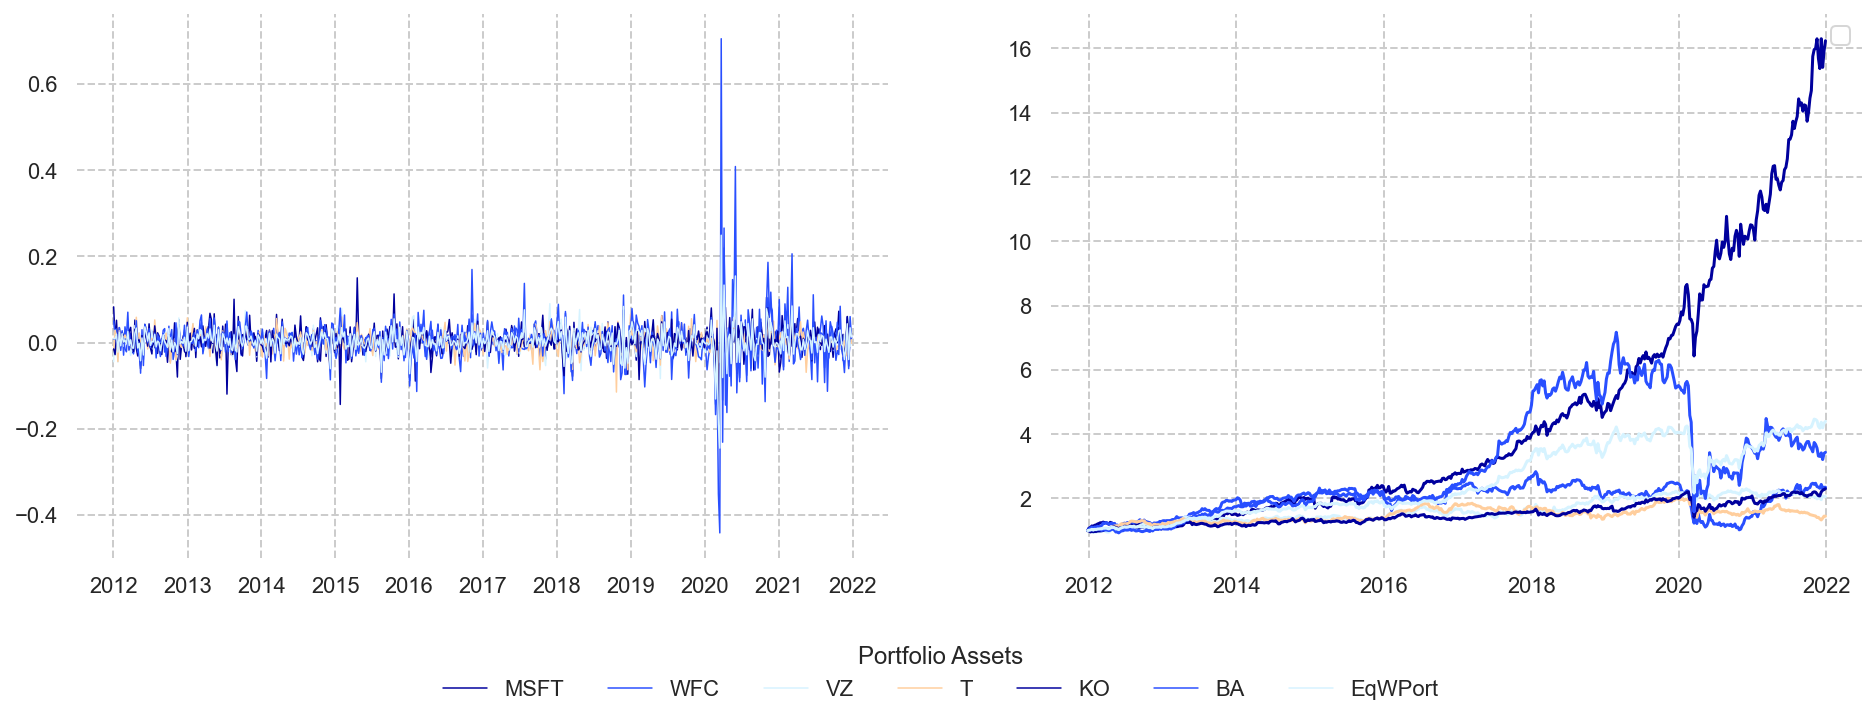

In [18]:
label = portfolio_codes

fig, ax = plt.subplots(1, 2)
ax[0].plot(portfolio_returns, linewidth=0.75)
ax[0].set_frame_on(False)

ax[1].plot(portfolio_data/portfolio_data.iloc[0])
ax[1].legend(prop={'size': 12})
ax[1].set_frame_on(False)

fig.set_size_inches((16, 5))
fig.legend(label, loc='lower center', ncol=len(portfolio_codes), frameon=False, title='Portfolio Assets', bbox_to_anchor=(0.5, -0.1))
plt.show()

### Value at Risk - Historical Overview

In the following section Value at Risk will be calculated over time; creating time series data of VaR which can be used later. One usage would be backtesting VaR models with different statistical test, which will be the next section. The value at risk measure will be calculated in three ways:

* Parametric approach
* Historical simulation 
* Histroical simulation with volatility adjustment acc. Hull & White

When using the parametric approach and volatility adjustment in historical simulation an appropriate volatility model is required. For this a EWMA model is used with decay-parameter $\lambda = 0.94$ described as:

$$
\sigma^2_t = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2 
$$

In [69]:
def generate_EWMA_volatility(data):
    if isinstance(data, pd.DataFrame):
        data = data.to_list()
    # Note: volatility is squared.
    # Lambda decay parameter according to RiskMetrics general fit.
    _n_observations = len(data)
    _ewma_vol = np.zeros(_n_observations)
    _lamb = 0.94
    
    _current_vol = data[0] ** 2
    _ewma_vol[0] = np.sqrt(_current_vol)
    
    for i in range(1, _n_observations):
        _current_vol = _lamb * _current_vol + (1 - _lamb) * (data[i-1] ** 2)
        _ewma_vol[i] = np.sqrt(_current_vol)

    return _ewma_vol

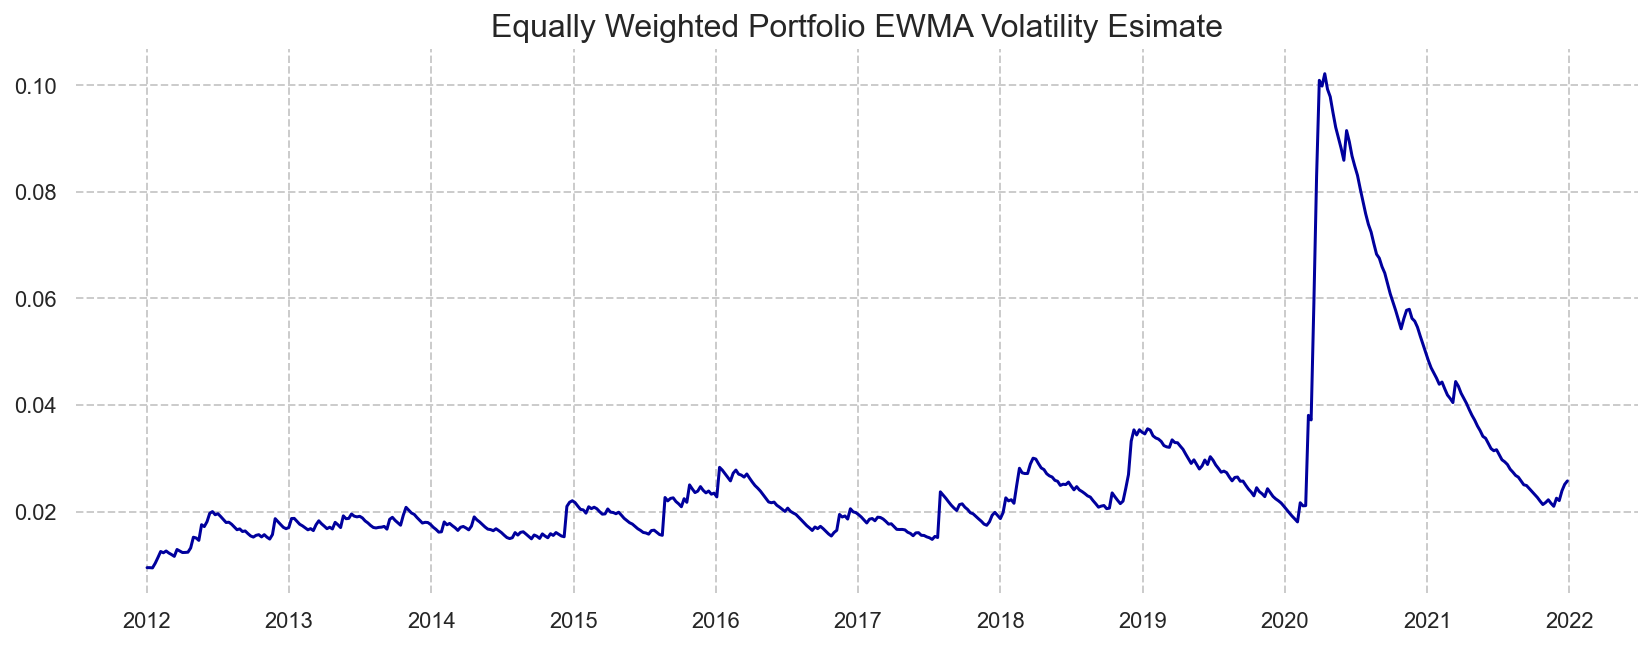

In [124]:
eqw_portfolio_returns = portfolio_returns['EqWPortfolio']
eqw_portfolio_volatility = generate_EWMA_volatility(portfolio_returns['EqWPortfolio'])

fig, ax = plt.subplots()
ax.plot(portfolio_returns.index, eqw_portfolio_volatility)
ax.set_frame_on(False)
ax.set_title("Equally Weighted Portfolio EWMA Volatility Esimate", fontsize=16)

fig.set_size_inches(14, 5)
plt.show()

##### 1. Paramteric Approach

Value at risk is asceratined through the following expresion:

$$
\textrm{VaR}_{\textrm{1wk},t}^{\textrm{p\%}} = \mu_p + \sigma_{p,t} \Phi^{-1}(p)
$$

Using the CLT we can test the hypothesis, whether or not $\mu_p = 0$. We create we confidence interval for the portfolio using historical data. With this we can reject the null hypothesis that $\mu_p = 0$.

The volatility $\sigma_{p,t}$ is estimated using the aforementioned EWMA model.

The quantile of the standard normal distribution $\Phi^{-1}(p)$ is simply found by using SciPy.

In [126]:
standard_error = eqw_portfolio_returns.std() / len(eqw_portfolio_returns)
mean_return = eqw_portfolio_returns.mean()

lower_limit = mean_return - standard_error
upper_limit = mean_return + standard_error

confidence_interval_mean_return = [lower_limit, upper_limit]
print('Mean Return Confidence Interval')
print(confidence_interval_mean_return)

Mean Return Confidence Interval
[0.00325970892592128, 0.0033773158785722415]


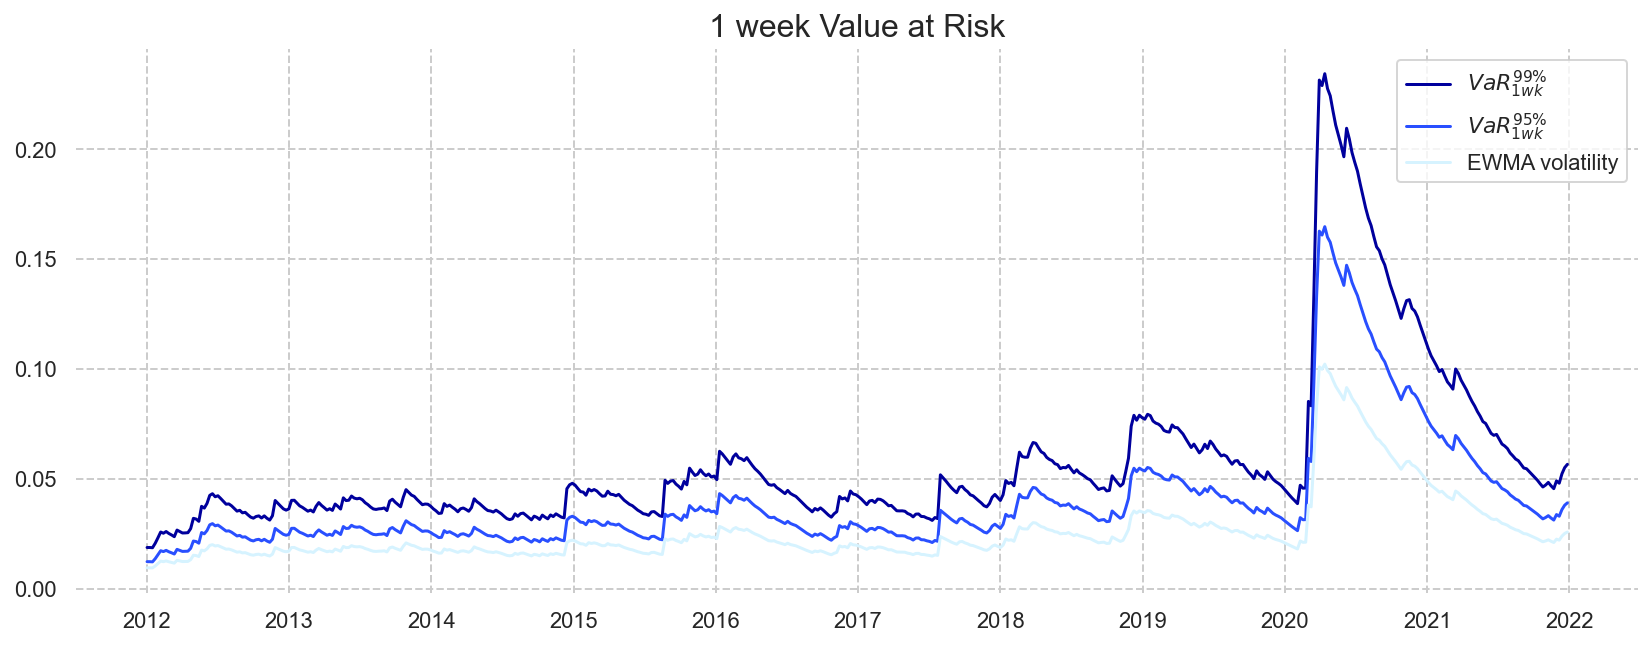

In [178]:
from scipy.stats import norm

var_portfolio_parametric_95 = mean_return + norm.ppf(0.05) * eqw_portfolio_volatility
var_portfolio_parametric_99 = mean_return + norm.ppf(0.01) * eqw_portfolio_volatility

fig, ax = plt.subplots()
ax.plot(portfolio_returns.index, -var_portfolio_parametric_99, label='${VaR}_{1wk}^{99\%}$')
ax.plot(portfolio_returns.index, -var_portfolio_parametric_95, label='${VaR}_{1wk}^{95\%}$')
ax.plot(portfolio_returns.index, eqw_portfolio_volatility, label='EWMA volatility')

ax.set_frame_on(False)
ax.set_title('1 week Value at Risk', fontsize=16)
fig.set_size_inches(14, 5)
ax.legend()
plt.show()

##### 2. Historical Simulation Approach
Using historical simulation we will use a rolling window of $50$ previous observations to calculate an empirical quantile to find Value at Risk.

In [174]:
from scipy.stats.mstats import mquantiles
def my_95_quantile(data):
    return mquantiles(data, prob=0.05)
def my_99_quantile(data):
    return mquantiles(data, prob=0.01)

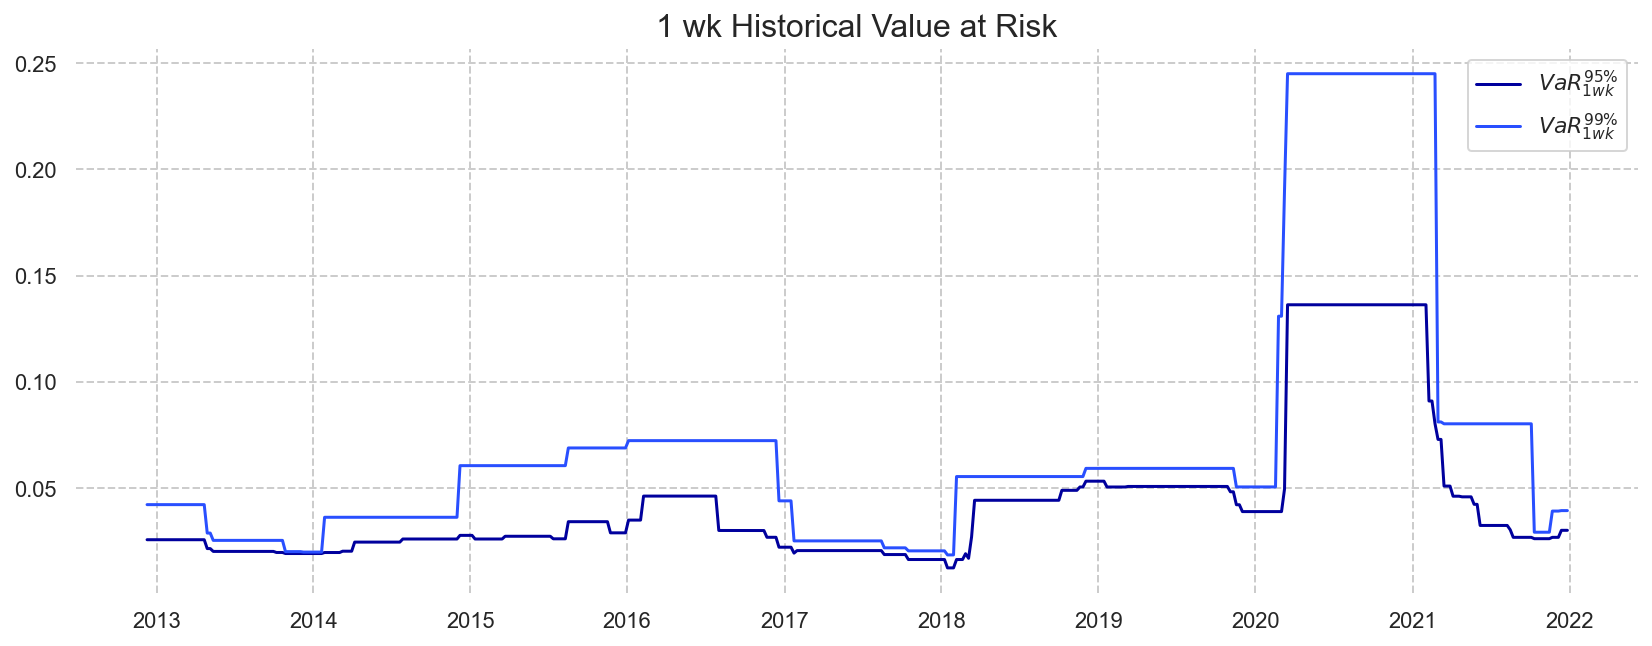

In [300]:
var_portfolio_historic_95 = eqw_portfolio_returns.rolling(50).apply(my_95_quantile)
var_portfolio_historic_99 = eqw_portfolio_returns.rolling(50).apply(my_99_quantile)

fig, ax = plt.subplots()

ax.plot(var_portfolio_historic_95.index, -var_portfolio_historic_95, label='${VaR}_{1wk}^{95\%}$')
ax.plot(var_portfolio_historic_99.index, -var_portfolio_historic_99, label='${VaR}_{1wk}^{99\%}$')
ax.set_frame_on(False)
ax.set_title('1 wk Historical Value at Risk', fontsize=16)
ax.legend()

fig.set_size_inches(14, 5)
plt.show()

##### 3. Historical Simulation Approach with Volatility Adjustment

Using historical simulation we first begin by standardizing the returns with the use of the mean return, and the time varying EWMA volatility. Second, we choose a window size and instill the last day's volatility to the entire window of standardized returns. Note, we must consider the mean after the new standardization has occured.

In [297]:
standarized_portfolio_returns = (eqw_portfolio_returns - mean_return) / eqw_portfolio_volatility

In [298]:
# Needs updating. Rolling does not allow for arguments in apply function.

global global_rolling_coutner_95, global_rolling_coutner_99
global_rolling_coutner_95 = 49
global_rolling_coutner_99 = 49

def volatility_adjustment_95(data):
    global global_rolling_coutner_95
    data = data * eqw_portfolio_volatility[global_rolling_coutner_95] + mean_return
    global_rolling_coutner_95 += 1    
    return mquantiles(data, prob=0.05)

def volatility_adjustment_99(data):
    global global_rolling_coutner_99
    data = data * eqw_portfolio_volatility[global_rolling_coutner_99] + mean_return
    global_rolling_coutner_99 += 1    
    return mquantiles(data, prob=0.01)

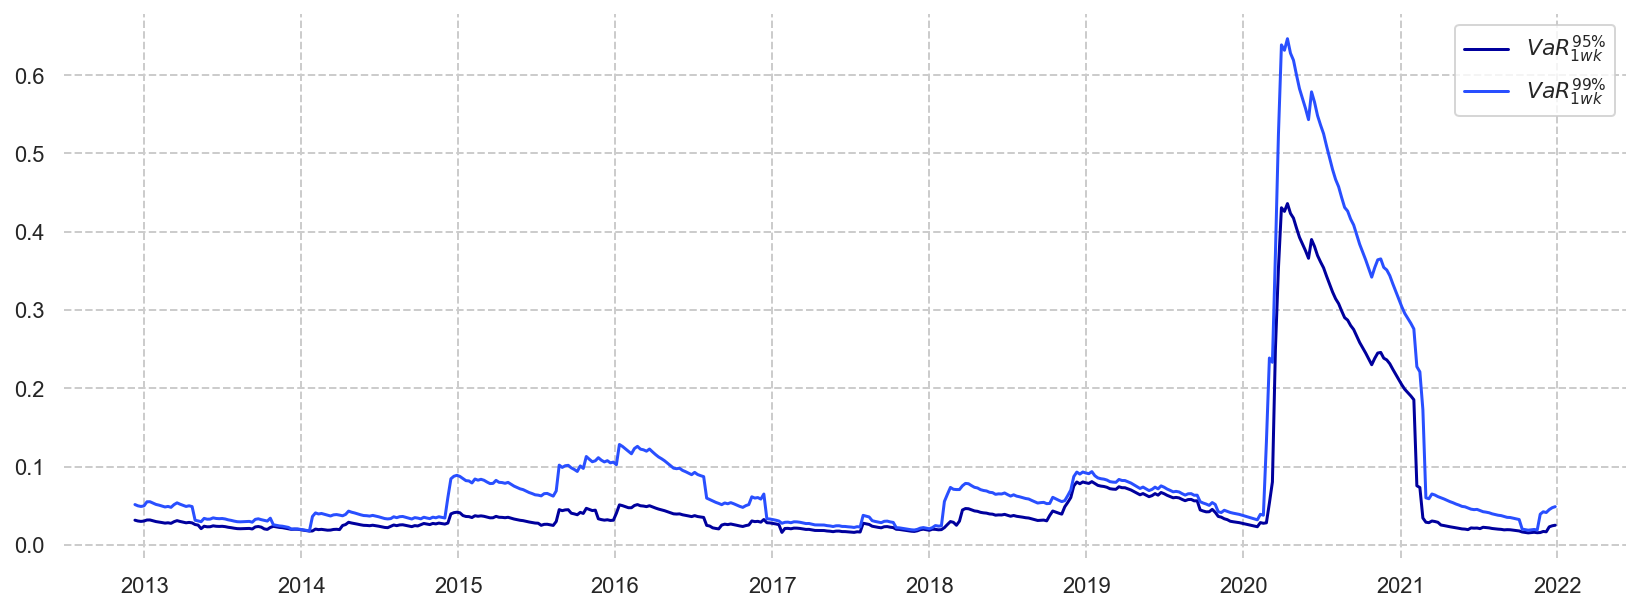

In [299]:
var_portfolio_historic__hw_95 = -standarized_portfolio_returns.rolling(50).apply(volatility_adjustment_95)
var_portfolio_historic__hw_99 = -standarized_portfolio_returns.rolling(50).apply(volatility_adjustment_99)

fig, ax = plt.subplots()
ax.plot(var_portfolio_historic__hw_95.index, var_portfolio_historic__hw_95, label='${VaR}_{1wk}^{95\%}$')
ax.plot(var_portfolio_historic__hw_99.index, var_portfolio_historic__hw_99, label='${VaR}_{1wk}^{99\%}$')
ax.set_frame_on(False)
ax.legend()

fig.set_size_inches(14, 5)
plt.show()

### Hypothesis Testing - Serial Dependence & VaR exceedences

Firstly, we can test if the VaR exceedences are serially dependend using the classical Christoffersson test, a likelihood ratio test. Secondly, we can examine how well the different models work, by confirming the number of VaR exceedences are consistent with the expected amount given a certain significance level.